In [1]:
import re
from datetime import datetime, timedelta
from typing import List, Dict, Tuple
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def get_free_intervals(busy_intervals: List[Dict[str, datetime]], 
                       day_start: datetime, 
                       day_end: datetime) -> List[Tuple[datetime, datetime]]:
    """
    Given a list of busy intervals (calendar events), computes free time slots 
    within the working day.
    """
    # Sort events by start time
    busy_intervals = sorted(busy_intervals, key=lambda x: x["start"])
    free_intervals: List[Tuple[datetime, datetime]] = []

    # Check for free time before the first event
    if busy_intervals and busy_intervals[0]["start"] > day_start:
        free_intervals.append((day_start, busy_intervals[0]["start"]))

    # Identify free slots between consecutive meetings
    for i in range(len(busy_intervals) - 1):
        current_end = busy_intervals[i]["end"]
        next_start = busy_intervals[i + 1]["start"]
        if current_end < next_start:
            free_intervals.append((current_end, next_start))

    # Check for free time after the last event
    if busy_intervals and busy_intervals[-1]["end"] < day_end:
        free_intervals.append((busy_intervals[-1]["end"], day_end))

    return free_intervals

def intersect_intervals(intervals1: List[Tuple[datetime, datetime]], 
                        intervals2: List[Tuple[datetime, datetime]]) -> List[Tuple[datetime, datetime]]:
    """
    Computes the intersection of two lists of free intervals.
    """
    i, j = 0, 0
    intersections: List[Tuple[datetime, datetime]] = []

    while i < len(intervals1) and j < len(intervals2):
        start1, end1 = intervals1[i]
        start2, end2 = intervals2[j]
        latest_start = max(start1, start2)
        earliest_end = min(end1, end2)
        if latest_start < earliest_end:
            intersections.append((latest_start, earliest_end))
        if end1 < end2:
            i += 1
        else:
            j += 1

    return intersections

def find_common_free_slot(calendars: List[List[Dict[str, datetime]]], 
                          day_start: datetime, 
                          day_end: datetime) -> List[Tuple[datetime, datetime]]:
    """
    Finds common available time slots for all participants within a single day.
    """
    free_intervals_list: List[List[Tuple[datetime, datetime]]] = []
    for calendar in calendars:
        free_intervals_list.append(get_free_intervals(calendar, day_start, day_end))
    common_free: List[Tuple[datetime, datetime]] = free_intervals_list[0]
    for free_intervals in free_intervals_list[1:]:
        common_free = intersect_intervals(common_free, free_intervals)
    return common_free

def filter_events_by_day(calendar: List[Dict[str, any]], 
                         day_start: datetime, 
                         day_end: datetime) -> List[Dict[str, any]]:
    """
    Returns events from the calendar that fall within the given day.
    """
    return [event for event in calendar if event["start"] >= day_start and event["start"] < day_end]

def find_common_free_slot_multi_day(calendars: List[List[Dict[str, any]]], 
                                    working_days: List[Tuple[datetime, datetime]]) -> List[datetime]:
    """
    Computes common free slots for multiple days and then returns a sorted list 
    of datetime objects (start and end times of free intervals) combined with 
    the start and end times of meetings where all three participants are involved.
    """
    free_boundaries = set()

    # Process each day separately
    for day_start, day_end in working_days:
        # For each calendar, filter events to just those in the day.
        daily_calendars = [filter_events_by_day(calendar, day_start, day_end) for calendar in calendars]
        daily_free = find_common_free_slot(daily_calendars, day_start, day_end)
        for start, end in daily_free:
            free_boundaries.add(start)
            free_boundaries.add(end)
    
    # Get full meetings (meetings with all three attendees) across all days.
    full_meetings = flag_full_meetings(calendars, ["Person1", "Person2", "Person3"])
    for meeting in full_meetings:
        free_boundaries.add(meeting["start"])
        free_boundaries.add(meeting["end"])
    
    # Return sorted list of datetime objects.
    return sorted(free_boundaries)

def print_intervals(intervals: List[Tuple[datetime, datetime]]) -> None:
    """
    Prints a list of time intervals in a human-readable format.
    """
    if not intervals:
        print("No common free slots available.")
        return
    for start, end in intervals:
        print(f"{start.strftime('%Y-%m-%d %H:%M')} to {end.strftime('%Y-%m-%d %H:%M')}")

def ensure_owner_in_meetings(calendar: List[Dict[str, any]], owner: str) -> None:
    """
    Ensures that each meeting in the given calendar includes the calendar owner's name 
    in the attendees list. If not, adds the owner.
    """
    for event in calendar:
        if "attendees" in event:
            if owner not in event["attendees"]:
                event["attendees"].append(owner)
        else:
            event["attendees"] = [owner]

def flag_full_meetings(calendars: List[List[Dict[str, any]]], 
                       required_attendees: List[str]) -> List[Dict[str, any]]:
    """
    Flags meetings that include all the required attendees.
    """
    all_events: List[Dict[str, any]] = []
    for calendar in calendars:
        all_events.extend(calendar)
    
    # Deduplicate events based on (start, end, title)
    unique_events: Dict[Tuple[datetime, datetime, str], Dict[str, any]] = {}
    for event in all_events:
        key = (event["start"], event["end"], event["title"])
        if key not in unique_events:
            unique_events[key] = event.copy()  # copy to avoid modifying original
        else:
            unique_events[key]["attendees"] = list(set(unique_events[key]["attendees"]) | set(event["attendees"]))
    
    flagged: List[Dict[str, any]] = []
    for event in unique_events.values():
        if all(attendee in event["attendees"] for attendee in required_attendees):
            flagged.append(event)
    return flagged

def flag_partial_meetings(calendars: List[List[Dict[str, any]]], 
                          pair: Tuple[str, str]) -> List[Dict[str, any]]:
    """
    Flags meetings that include both persons specified in the pair.
    """
    all_events: List[Dict[str, any]] = []
    for calendar in calendars:
        all_events.extend(calendar)
    
    unique_events: Dict[Tuple[datetime, datetime, str], Dict[str, any]] = {}
    for event in all_events:
        key = (event["start"], event["end"], event["title"])
        if key not in unique_events:
            unique_events[key] = event.copy()
        else:
            unique_events[key]["attendees"] = list(set(unique_events[key]["attendees"]) | set(event["attendees"]))
    
    flagged: List[Dict[str, any]] = []
    for event in unique_events.values():
        if all(person in event["attendees"] for person in pair):
            flagged.append(event)
    return flagged

## Simulate calendar for 3 days

In [ ]:
from datetime import datetime, timedelta
from typing import List, Dict, Tuple

def working_hours(day: datetime) -> Tuple[datetime, datetime]:
    return (datetime(day.year, day.month, day.day, 8, 0), datetime(day.year, day.month, day.day, 18, 0))

days = [datetime(2025, 5, 1), datetime(2025, 5, 2), datetime(2025, 5, 3)]
working_days = [working_hours(day) for day in days]

def create_person_calendar(person: str) -> List[Dict[str, any]]:
    calendar = []
    if person == "Person1":
        calendar.extend([
            {"start": datetime(2025, 5, 1, 9, 0), "end": datetime(2025, 5, 1, 10, 0), 
             "title": "User Requirements Gathering", "attendees": ["Person1", "FakePersonA"]},
            {"start": datetime(2025, 5, 1, 14, 0), "end": datetime(2025, 5, 1, 15, 0), 
             "title": "Design Review", "attendees": ["Person1", "FakePersonB"]},
            {"start": datetime(2025, 5, 2, 11, 0), "end": datetime(2025, 5, 2, 12, 0), 
             "title": "Sprint Planning", "attendees": ["Person1", "Person2"]},
            {"start": datetime(2025, 5, 3, 16, 0), "end": datetime(2025, 5, 3, 17, 0), 
             "title": "Team Sync", "attendees": ["Person1", "Person2", "Person3"]},
            {"start": datetime(2025, 5, 3, 10, 0), "end": datetime(2025, 5, 3, 11, 0), 
             "title": "Project Planning", "attendees": ["Person1", "FakePersonF"]}
        ])
    elif person == "Person2":
        calendar.extend([
            {"start": datetime(2025, 5, 1, 9, 0), "end": datetime(2025, 5, 1, 9, 30), 
             "title": "Scrum Standup", "attendees": ["Person2", "Agile Team"]},
            {"start": datetime(2025, 5, 1, 13, 0), "end": datetime(2025, 5, 1, 14, 0), 
             "title": "Client Demo", "attendees": ["Person2", "FakePersonC"]},
            {"start": datetime(2025, 5, 2, 11, 0), "end": datetime(2025, 5, 2, 12, 0), 
             "title": "Sprint Planning", "attendees": ["Person1", "Person2"]},
            {"start": datetime(2025, 5, 3, 16, 0), "end": datetime(2025, 5, 3, 17, 0), 
             "title": "Team Sync", "attendees": ["Person1", "Person2", "Person3"]},
            {"start": datetime(2025, 5, 3, 14, 0), "end": datetime(2025, 5, 3, 15, 0), 
             "title": "Budget Review", "attendees": ["Person2", "FakePersonG"]}
        ])
    elif person == "Person3":
        calendar.extend([
            {"start": datetime(2025, 5, 1, 10, 0), "end": datetime(2025, 5, 1, 11, 0), 
             "title": "Tech Deep Dive", "attendees": ["Person3", "FakePersonD"]},
            {"start": datetime(2025, 5, 2, 14, 0), "end": datetime(2025, 5, 2, 15, 0), 
             "title": "Architecture Review", "attendees": ["Person3", "FakePersonE"]},
            {"start": datetime(2025, 5, 3, 16, 0), "end": datetime(2025, 5, 3, 17, 0), 
             "title": "Team Sync", "attendees": ["Person1", "Person2", "Person3"]},
            {"start": datetime(2025, 5, 3, 9, 0), "end": datetime(2025, 5, 3, 10, 0), 
             "title": "Code Review", "attendees": ["Person3", "FakePersonH"]}
        ])
    return calendar

person1_calendar = create_person_calendar("Person1")
person2_calendar = create_person_calendar("Person2")
person3_calendar = create_person_calendar("Person3")

### Visualize calendars

In [3]:
## Seaborn

import textwrap
import seaborn as sns

def plot_calendars_by_day(calendars: List[List[Dict[str, any]]], 
                          person_labels: List[str], 
                          working_days: List[Tuple[datetime, datetime]]) -> None:
    """
    Plots a horizontal bar chart for each day, showing the events from each person's calendar.
    Each subplot represents one day. Seaborn is used for styling.
    """
    sns.set(style="whitegrid")
    n_days = len(working_days)
    fig, axes = plt.subplots(n_days, 1, figsize=(12, n_days * 3), sharex=False)
    
    # Ensure axes is iterable
    if n_days == 1:
        axes = [axes]
    
    colors = plt.cm.tab10.colors  # Colors for events
    wrap_width = 10  # Maximum characters per line for event titles
    
    for day_idx, (day_start, day_end) in enumerate(working_days):
        ax = axes[day_idx]
        day_str = day_start.strftime("%Y-%m-%d")
        ax.set_title(f"Calendar for {day_str}")
        
        # For each person's calendar, filter events for the day and plot them.
        for i, (calendar, label) in enumerate(zip(calendars, person_labels)):
            # Filter events that start within this day.
            events = [event for event in calendar if event["start"] >= day_start and event["start"] < day_end]
            for event in events:
                start = event["start"]
                end = event["end"]
                duration = mdates.date2num(end) - mdates.date2num(start)
                # Plot as a horizontal bar; y position is the index of the person.
                ax.barh(i, duration, left=mdates.date2num(start), height=0.4,
                        color=colors[i % len(colors)], alpha=0.6, edgecolor='k')
                # Wrap the event title text to avoid overlapping.
                wrapped_title = textwrap.fill(event["title"], width=wrap_width)
                ax.text(mdates.date2num(start) + duration/2, i, wrapped_title,
                        ha='center', va='center', color='black', fontsize=8)
        
        ax.set_yticks(range(len(calendars)))
        ax.set_yticklabels(person_labels)
        # Format the x-axis to show time only.
        ax.xaxis_date()
        date_format = mdates.DateFormatter('%H:%M')
        ax.xaxis.set_major_formatter(date_format)
        ax.set_xlabel("Time")
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

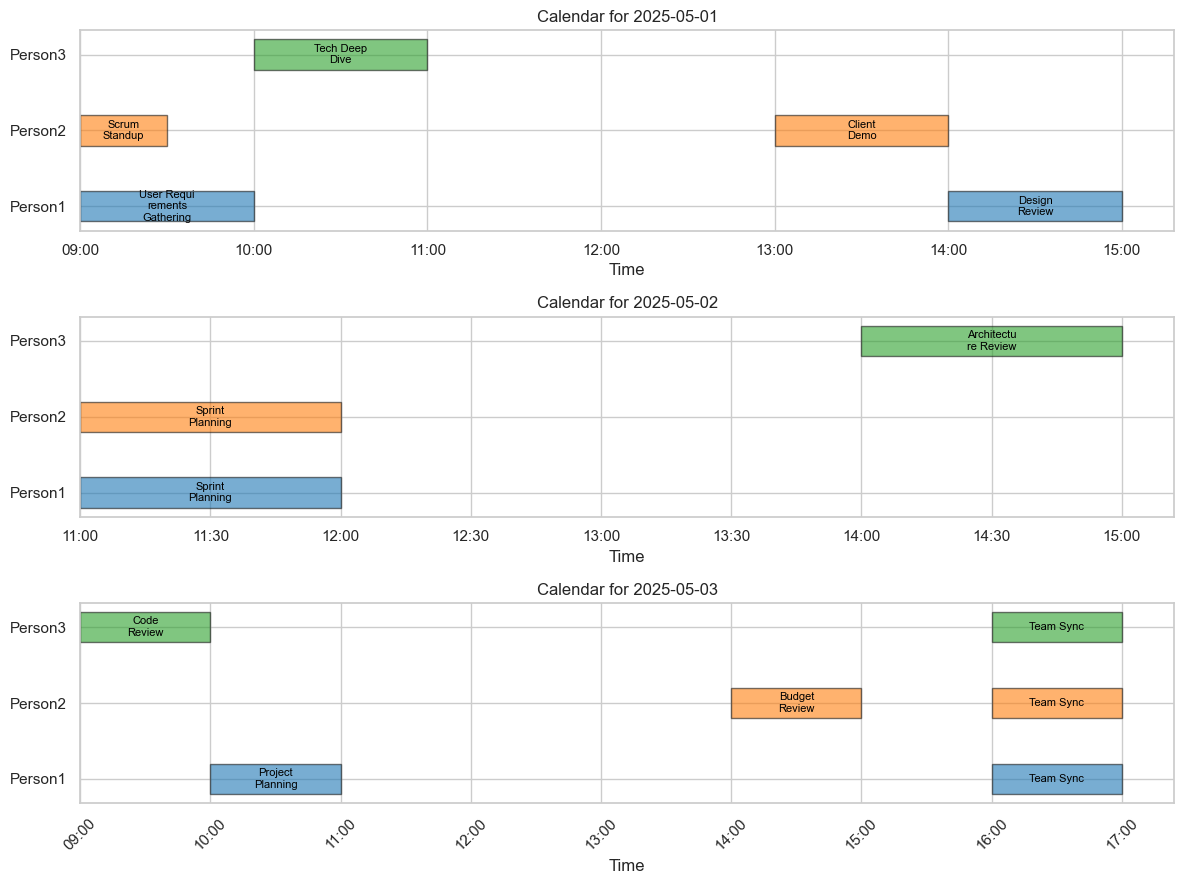

In [4]:
def plotly_calendars_by_day(calendars: List[List[Dict[str, any]]],
                            person_labels: List[str],
                            working_days: List[Tuple[datetime, datetime]]) -> None:
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots

    n_days = len(working_days)
    fig = make_subplots(rows=n_days, cols=1, shared_xaxes=False, vertical_spacing=0.1)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

    for day_idx, (day_start, day_end) in enumerate(working_days):
        row = day_idx + 1
        day_str = day_start.strftime("%Y-%m-%d")
        fig.add_annotation(
            dict(text=f"Calendar for {day_str}",
                 xref=f"x{row}" if row > 1 else "x",
                 yref=f"y{row}" if row > 1 else "y",
                 x=0.5, y=1.15, showarrow=False,
                 xanchor="center", yanchor="top", font=dict(size=14)),
            row=row, col=1
        )
        fig.update_yaxes(title_text="", tickmode="array",
                         tickvals=list(range(len(person_labels))),
                         ticktext=person_labels,
                         range=[-0.5, len(person_labels)-0.5],
                         row=row, col=1)
        fig.update_xaxes(type="date", title_text="Time", row=row, col=1)

        for i, (calendar, label) in enumerate(zip(calendars, person_labels)):
            day_events = [event for event in calendar if event["start"] >= day_start and event["start"] < day_end]
            for event in day_events:
                start = event["start"]
                end = event["end"]
                fig.add_shape(
                    type="rect",
                    xref=f"x{row}" if row > 1 else "x",
                    yref=f"y{row}" if row > 1 else "y",
                    x0=start, x1=end,
                    y0=i - 0.2, y1=i + 0.2,
                    line=dict(color="black"),
                    fillcolor=colors[i % len(colors)],
                    row=row, col=1
                )
                fig.add_annotation(
                    x=start + (end - start) / 2,
                    y=i,
                    text=event["title"],
                    showarrow=False,
                    font=dict(color="black", size=10),
                    xref=f"x{row}" if row > 1 else "x",
                    yref=f"y{row}" if row > 1 else "y",
                    row=row, col=1
                )
    fig.update_layout(height=300 * n_days, title_text="Calendars by Day", showlegend=False)
    fig.show()

# Call the plotting function with labels for each calendar
person_labels = ["Person1", "Person2", "Person3"]
calendars = [person1_calendar, person2_calendar, person3_calendar]
plot_calendars_by_day(calendars, person_labels, working_days=working_days)

In [5]:
# Compute common free slots across multiple days and combine with full meeting boundaries.
common_boundaries = find_common_free_slot_multi_day(calendars, working_days)

print("Sorted datetime boundaries (free slots and full meetings boundaries):")
for dt in common_boundaries:
    print(dt.strftime('%Y-%m-%d %H:%M'))

# Compute and print the common free intervals for all working days.
print("\nCommon free intervals for all three days:")
for day_start, day_end in working_days:
    print(f"Date: {day_start.strftime('%Y-%m-%d')}")
    day_calendars = [filter_events_by_day(calendar, day_start, day_end) for calendar in calendars]
    common_free = find_common_free_slot(day_calendars, day_start, day_end)
    print_intervals(common_free)

# Now, flag meetings:
full_meetings = flag_full_meetings(calendars, ["Person1", "Person2", "Person3"])
print("\nMeetings with all three attendees:")
for meeting in full_meetings:
    attendees = ", ".join(meeting["attendees"])
    print(f"{meeting['title']} from {meeting['start'].strftime('%Y-%m-%d %H:%M')} to {meeting['end'].strftime('%Y-%m-%d %H:%M')} (Attendees: {attendees})")

partial_meetings = flag_partial_meetings(calendars, ("Person1", "Person2"))
print("\nMeetings with Person1 and Person2:")
for meeting in partial_meetings:
    attendees = ", ".join(meeting["attendees"])
    print(f"{meeting['title']} from {meeting['start'].strftime('%Y-%m-%d %H:%M')} to {meeting['end'].strftime('%Y-%m-%d %H:%M')} (Attendees: {attendees})")

Sorted datetime boundaries (free slots and full meetings boundaries):
2025-05-01 08:00
2025-05-01 09:00
2025-05-01 11:00
2025-05-01 13:00
2025-05-01 15:00
2025-05-01 18:00
2025-05-02 08:00
2025-05-02 11:00
2025-05-02 12:00
2025-05-02 14:00
2025-05-02 15:00
2025-05-02 18:00
2025-05-03 08:00
2025-05-03 09:00
2025-05-03 11:00
2025-05-03 14:00
2025-05-03 15:00
2025-05-03 16:00
2025-05-03 17:00
2025-05-03 18:00

Common free intervals for all three days:
Date: 2025-05-01
2025-05-01 08:00 to 2025-05-01 09:00
2025-05-01 11:00 to 2025-05-01 13:00
2025-05-01 15:00 to 2025-05-01 18:00
Date: 2025-05-02
2025-05-02 08:00 to 2025-05-02 11:00
2025-05-02 12:00 to 2025-05-02 14:00
2025-05-02 15:00 to 2025-05-02 18:00
Date: 2025-05-03
2025-05-03 08:00 to 2025-05-03 09:00
2025-05-03 11:00 to 2025-05-03 14:00
2025-05-03 15:00 to 2025-05-03 16:00
2025-05-03 17:00 to 2025-05-03 18:00

Meetings with all three attendees:
Team Sync from 2025-05-03 16:00 to 2025-05-03 17:00 (Attendees: Person2, Person1, Person3)

In [6]:
def add_event_to_calendars(
    start: datetime, 
    end: datetime, 
    title: str, 
    affected_people: List[str], 
    calendars_mapping: Dict[str, List[Dict[str, any]]]) -> bool:
    """
    Adds an event to the calendars of specified people if the time slot is free.
    
    Parameters:
        start (datetime): The start time of the event.
        end (datetime): The end time of the event.
        title (str): Title of the event.
        affected_people (List[str]): List of people whose calendars are affected.
        calendars_mapping (Dict[str, List[Dict[str, any]]]): A mapping from person names to their calendar events.
        
    Returns:
        bool: True if event was successfully added to all calendars, False if any calendar is busy.
    """
    def is_free(calendar: List[Dict[str, any]], start: datetime, end: datetime) -> bool:
        for event in calendar:
            # Check if the new event overlaps with any existing event.
            if not (end <= event["start"] or start >= event["end"]):
                return False
        return True

    # Verify availability for each affected person.
    for person in affected_people:
        cal = calendars_mapping.get(person)
        if cal is None or not is_free(cal, start, end):
            print(f"Time slot not available for {person}.")
            return False

    # Build new event and add to each calendar.
    event = {"start": start, "end": end, "title": title, "attendees": affected_people.copy()}
    for person in affected_people:
        calendars_mapping[person].append(event)
    print("Event added successfully to calendars: " + ", ".join(affected_people))
    return True

# Example usage:
add_event_to_calendars(
    datetime(2025, 5, 2, 15, 0), 
    datetime(2025, 5, 2, 16, 0), 
    "New Team Meeting", 
    ["Person1", "Person2", "Person3"], 
    {"Person1": person1_calendar, "Person2": person2_calendar, "Person3": person3_calendar} 
)

Event added successfully to calendars: Person1, Person2, Person3


True

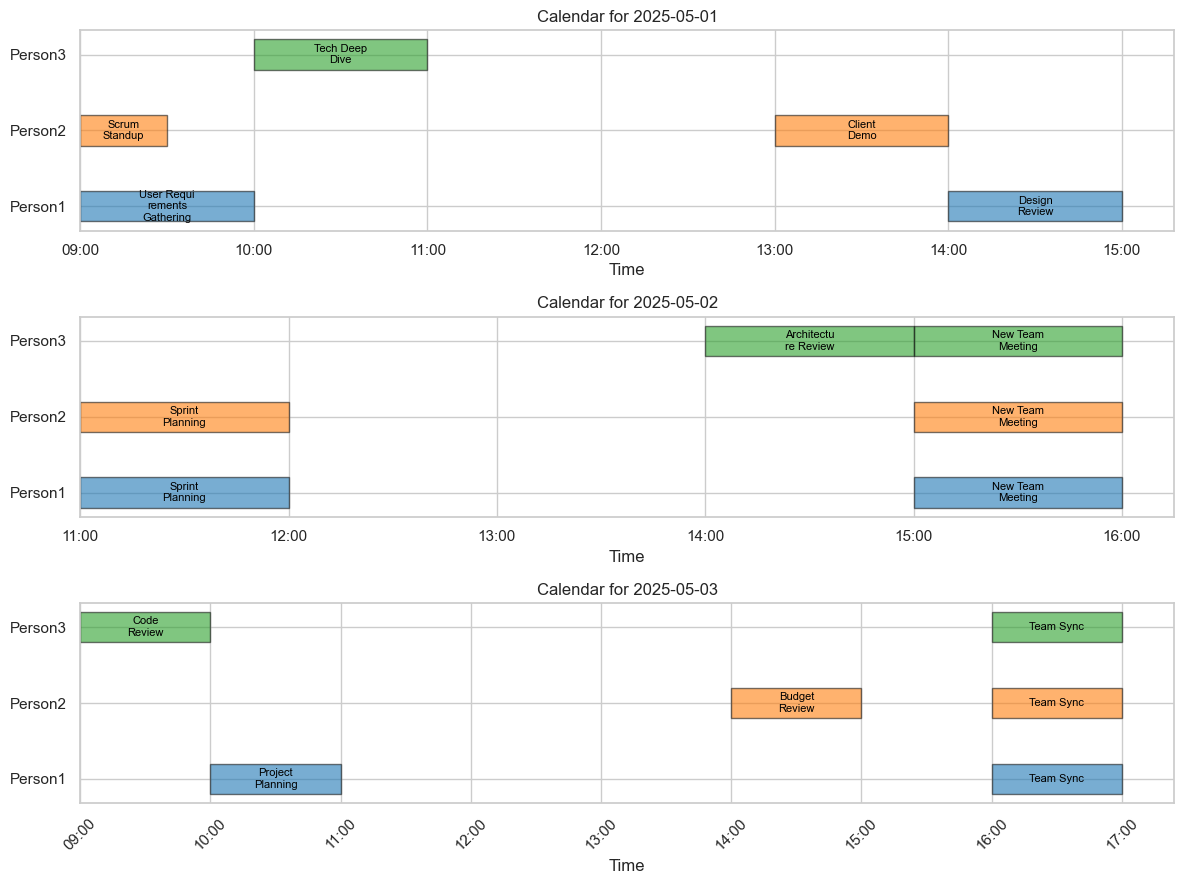

In [7]:
calendars: List[List[Dict[str, any]]] = [person1_calendar, person2_calendar, person3_calendar]
plot_calendars_by_day(calendars, person_labels, working_days=working_days)